# Effective DOF test

## Import package

In [34]:
import numpy as np
import netCDF4 as nc

from scipy import stats
from matplotlib.colors import TwoSlopeNorm
from matplotlib import pyplot as plt

## Load data

In [35]:
# Load MPAS data
## dimension
dims: dict[str, np.ndarray] = dict()

data: dict[str, np.ndarray] = dict()


## variables
with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/CNTL/theta.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:]

    lat_lim: list[int] = np.where((dims["lat"][:] >= -5) & (dims["lat"][:] <= 5))[0]

    data["temp"] = (f.variables["theta"][:, :, lat_lim, :].mean(axis=2) * (1000/dims["lev"])[None, :, None]**(-0.286)) - 273.15

ltime, llev, llon = data["temp"].shape

with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/CNTL/rthratenlw.nc", "r") as f:
    data["lw"] = ((f.variables["rthratenlw"][:, :, lat_lim, :].mean(axis=2) * (1000/dims["lev"])[None, :, None]**(-0.286)) - 273.15) * 86400


with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/CNTL/rthratensw.nc", "r") as f:
    data["sw"] = ((f.variables["rthratensw"][:, :, lat_lim, :].mean(axis=2) * (1000/dims["lev"])[None, :, None]**(-0.286)) - 273.15) * 86400


# load events
lon_ref, time_ref = np.load(
        "/home/b11209013/2024_Research/MPAS/Composite/Q1_event_sel/Q1_sel/CNTL.npy"
    )

### Acquiring anomaly

In [36]:
for key in data.keys():
    data[key] -= data[key].mean(axis=(0, 2))[None, :, None]

## Systematic Event selection

### Time interval setting

In [37]:
time_itv = np.array([
        np.linspace(time_ref[i]-12, time_ref[i]+12, 25)
        for i in range(time_ref.shape[0])
    ])

### Event selection

In [38]:
data_sel: dict[str, np.ndarray] = dict()

for key in data.keys():
    data_sel[key] = np.array([
        data[key][time_itv[i].astype(int), :, lon_ref[i].astype(int)]
        for i in range(time_ref.shape[0])
    ]).mean(axis=0).T
    
print(data_sel["temp"].shape)

(38, 25)


### Compositing

Text(0.5, 1.0, 'Correlation between temperature and radiation')

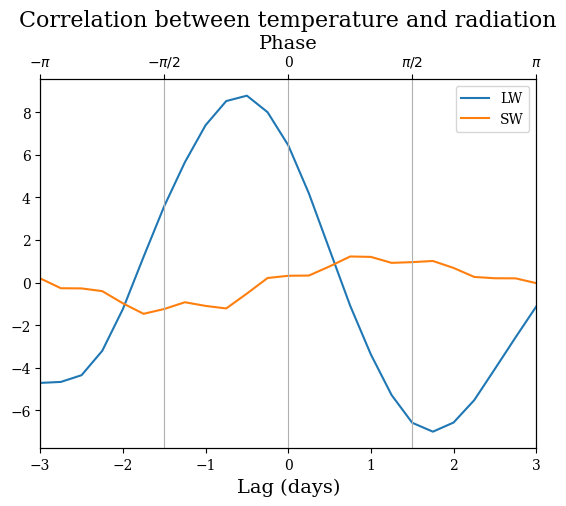

In [39]:
from cProfile import label


lw_t = np.empty((llev, 25))
sw_t = np.empty((llev, 25))

for i in range(llev):
    lw_t[i] = np.correlate(data_sel["lw"][i] - data_sel["lw"][i].mean(), data_sel["temp"][i] - data_sel["temp"][i].mean(), mode="same")
    sw_t[i] = np.correlate(data_sel["sw"][i], data_sel["temp"][i], mode="same")

lev_300 = np.argmin(np.abs(dims["lev"] - 300))

plt.rcParams.update({
    'font.size': 10,
    'figure.titlesize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'font.family': 'serif',
})

fig, ax1 = plt.subplots()
ax1.plot(np.linspace(-3, 3, 25), lw_t[lev_300], label="LW")
ax1.plot(np.linspace(-3, 3, 25), sw_t[lev_300], label="SW")
ax1.set_xticks(np.linspace(-3, 3, 7))
ax1.set_xlim(-3, 3)
ax1.set_xlabel("Lag (days)")
plt.legend()

ax2 = ax1.twiny()
ax2.set_xticks(np.linspace(-np.pi, np.pi, 5), ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
ax2.set_xlabel("Phase")
plt.grid()
plt.title("Correlation between temperature and radiation")